In [1]:
import json

file_path = 'filterting/output-bielik/scores.json'

# Read JSON data from the file
with open(file_path, 'r', encoding='utf-8') as file:
    data_bielik = json.load(file)

file_path = 'filterting/output-gpt-4o-mini/scores.json'

# Read JSON data from the file
with open(file_path, 'r', encoding='utf-8') as file:
    data_mini = json.load(file)

file_path = 'filterting/output-gpt-4.1-nano/scores.json'

# Read JSON data from the file
with open(file_path, 'r', encoding='utf-8') as file:
    data_nano = json.load(file)


In [2]:
for data in [data_bielik, data_mini, data_nano]:
    for k,v in data.items():
        for k1,v1 in v.items():
            if 'tak' in v1[1] and 'nie' in v1[1]:
                v1[1] = 'err'
            elif 'tak' in v1[1]:
                v1[1] = 'tak'
            elif 'nie' in v1[1]:
                v1[1] = 'nie'
            else:
                v1[1] = 'err'

In [3]:
def get_RES(data):
    RES = {}
    for key2, value2 in data.items():
        res1 = []
        res2 = []
        res3 = []
        for key1, value1 in value2.items():
            r_num, r_str, lab = value1
            res1.append(r_num)
            res2.append(r_str)
            res3.append(lab)
        RES[key2] = [res1, res2, res3]
    return RES

In [4]:
import numpy as np

def precision_recall_at_k(scores, true_labels, k):
    ranked_indices = np.argsort(scores)[::-1]  # descending sort
    top_k = ranked_indices[:k]
    pred_labels = np.zeros(len(scores), dtype=int)
    pred_labels[top_k] = 1
    TP = sum((pred_labels == 1) & (true_labels == 1))
    FP = sum((pred_labels == 1) & (true_labels == 0))
    FN = sum((pred_labels == 0) & (true_labels == 1))
    if key == 'All Categories Combined':
        print(model, 'K:', k)
        print(TP, FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall


RES_models = {}
for model in ['bielik-1.5B-v3.0', "gpt-4-1-nano", "gpt-4o-mini"]:
    if model == 'bielik-1.5B-v3.0':
        data = data_bielik
    if model == 'gpt-4-1-nano':
        data = data_nano
    if model == 'gpt-4o-mini':
        data = data_mini

    RES = get_RES(data)
    RES_metrics = {}
    for key, value in RES.items():
        RES_metrics[key] = {}

        res_num, res_str, res_lab = value
        error_num = len([True for r1 in res_num if r1 == -1]) / len(res_num)
        error_str = len([True for r2 in res_str if r2 == 'err']) / len(res_str)

        mean_true = np.mean([r1 for r1, lab in zip(res_num, res_lab) if r1 != -1 and lab == key])
        mean_false = np.mean([r1 for r1, lab in zip(res_num, res_lab) if r1 != -1 and lab != key])

        # Filter out 'err' entries for classification counts
        filtered = [(r1, lab) for r1, lab in zip(res_str, res_lab) if r1 != 'err']
        TP = sum(1 for r1, lab in filtered if r1 == 'tak' and lab == key)
        TN = sum(1 for r1, lab in filtered if r1 == 'nie' and lab != key)
        FP = sum(1 for r1, lab in filtered if r1 == 'tak' and lab != key)
        FN = sum(1 for r1, lab in filtered if r1 == 'nie' and lab == key)

        # Calculate metrics with protection against division by zero
        total = TP + TN + FP + FN
        RES_metrics[key]['accuracy'] = (TP + TN) / total if total > 0 else 0
        RES_metrics[key]['precision'] = TP / (TP + FP) if (TP + FP) > 0 else 0
        RES_metrics[key]['recall'] = TP / (TP + FN) if (TP + FN) > 0 else 0

        RES_metrics[key]['len'] = len(res_num)
        RES_metrics[key]['error_num'] = error_num
        RES_metrics[key]['error_str'] = error_str
        RES_metrics[key]['valid_num'] = 1 - error_num
        RES_metrics[key]['valid_str'] = 1 - error_str

        RES_metrics[key]['mean_true'] = mean_true
        RES_metrics[key]['mean_false'] = mean_false


        combined_scores = list(res_num)
        combined_labels = [int(lab == key) for lab in res_lab]

        # Remove samples where score == -1 if those indicate invalid samples
        valid_indices = [i for i, score in enumerate(combined_scores) if score != -1]
        filtered_scores = np.array([combined_scores[i] for i in valid_indices])
        filtered_labels = np.array([combined_labels[i] for i in valid_indices])

        RES_metrics[key]['Precision@5'], RES_metrics[key]['Recall@5'] = precision_recall_at_k(filtered_scores, filtered_labels, 5)
        RES_metrics[key]['Precision@10'], RES_metrics[key]['Recall@10'] = precision_recall_at_k(filtered_scores, filtered_labels, 10)
        RES_metrics[key]['Precision@50'], RES_metrics[key]['Recall@50'] = precision_recall_at_k(filtered_scores, filtered_labels, 50)

    RES_models[model] = RES_metrics


In [5]:
RES_models['bielik-1.5B-v3.0'].keys()

dict_keys(['Języki i kultury świata', 'Historia i archeologia', 'Socjologia i antropologia', 'Równość i prawa człowieka'])

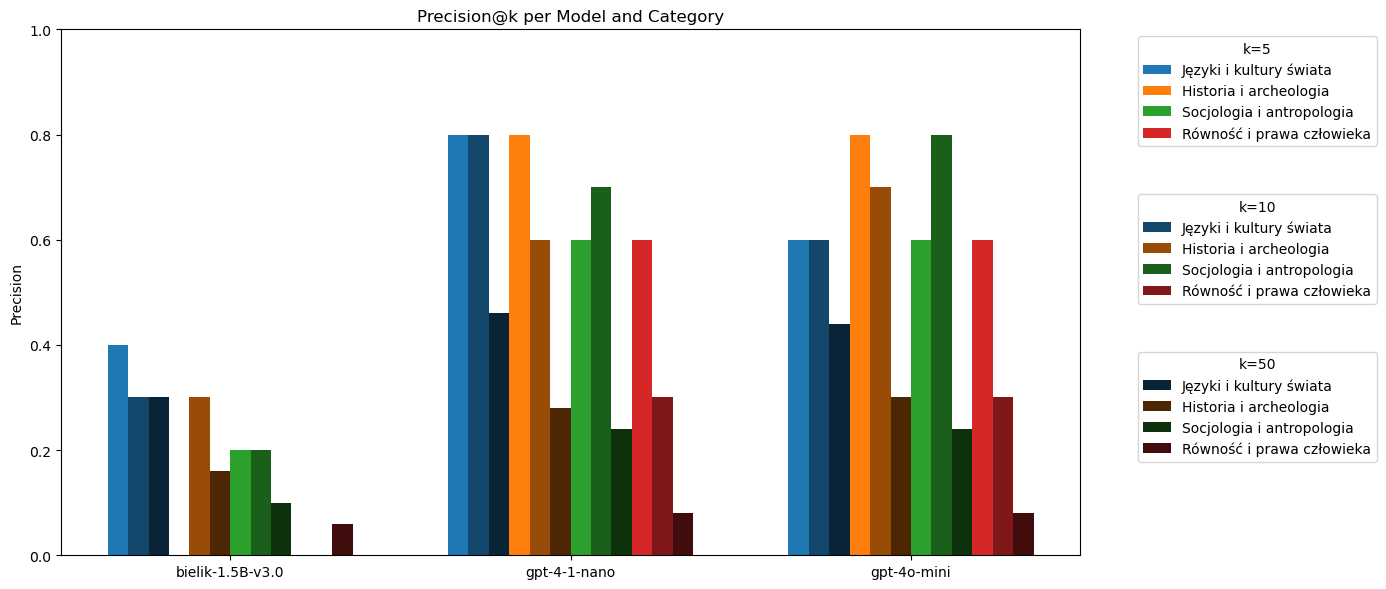

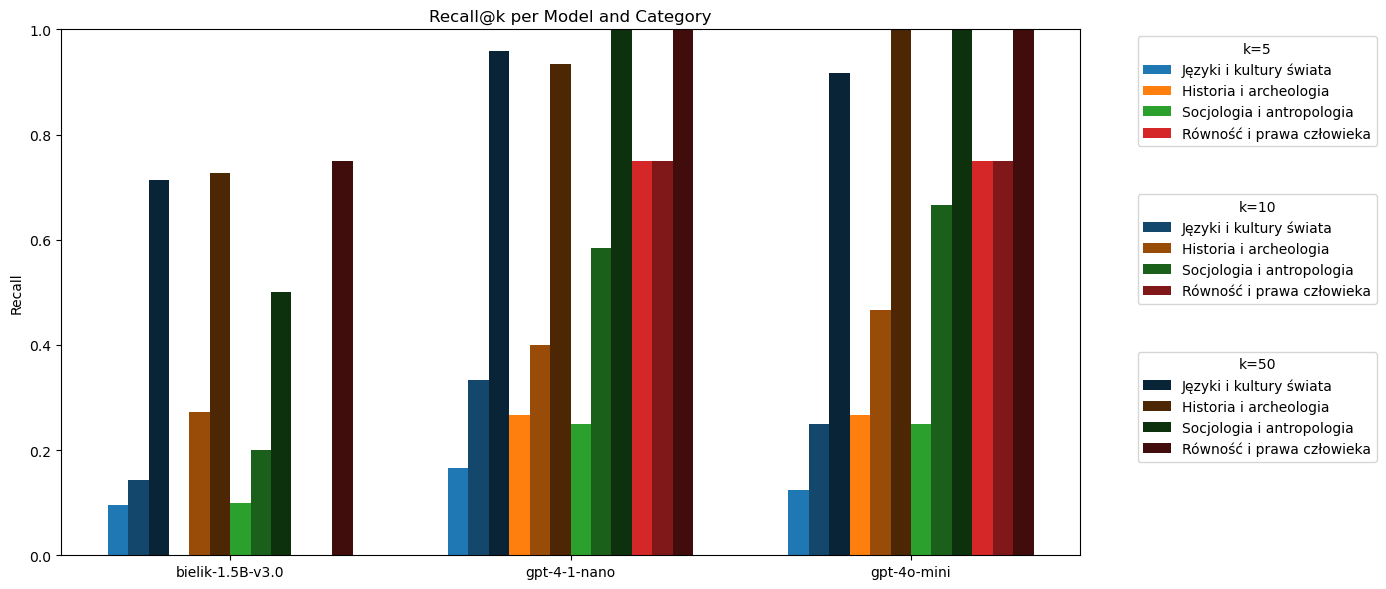

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

data = RES_models
models = list(data.keys())
categories = list(next(iter(data.values())).keys())
k_values = [5, 10, 50]  # Three k values

bar_width = 0.06
n_metrics = len(k_values)
n_categories = len(categories)
total_width = n_metrics * n_categories * bar_width

x = np.arange(len(models))
colors = plt.get_cmap('tab10').colors[:n_categories]

def plot_metric_grouped(metric_name):
    fig, ax = plt.subplots(figsize=(14, 6))

    # Prepare separate handles/labels for each k
    legend_handles_k = {k: [] for k in k_values}
    legend_labels_k = {k: [] for k in k_values}

    for i_cat, cat in enumerate(categories):
        base_color = colors[i_cat]
        for i_k, k in enumerate(k_values):
            values = [data[model][cat][f'{metric_name}@{k}'] for model in models]
            brightness = {5: 1.0, 10: 0.6, 50: 0.3}[k]
            color = mcolors.to_rgba(base_color)
            color = (color[0]*brightness, color[1]*brightness, color[2]*brightness, color[3])

            offset = (i_cat * n_metrics + i_k) * bar_width - total_width / 2 + bar_width / 2
            bars = ax.bar(x + offset, values, bar_width, color=color)

            legend_handles_k[k].append(bars[0])  # One bar for legend per category per k
            legend_labels_k[k].append(f'{cat}')


    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylabel(metric_name)
    ax.set_ylim(0, 1)
    ax.set_title(f'{metric_name}@k per Model and Category')

    # Place legends stacked vertically with spacing
    legend1 = ax.legend(legend_handles_k[5], legend_labels_k[5], title='k=5',
                        bbox_to_anchor=(1.05, 1), loc='upper left')
    legend2 = ax.legend(legend_handles_k[10], legend_labels_k[10], title='k=10',
                        bbox_to_anchor=(1.05, 0.7), loc='upper left')
    legend3 = ax.legend(legend_handles_k[50], legend_labels_k[50], title='k=50',
                        bbox_to_anchor=(1.05, 0.4), loc='upper left')

    ax.add_artist(legend1)
    ax.add_artist(legend2)

    plt.tight_layout()
    plt.show()

plot_metric_grouped('Precision')
plot_metric_grouped('Recall')


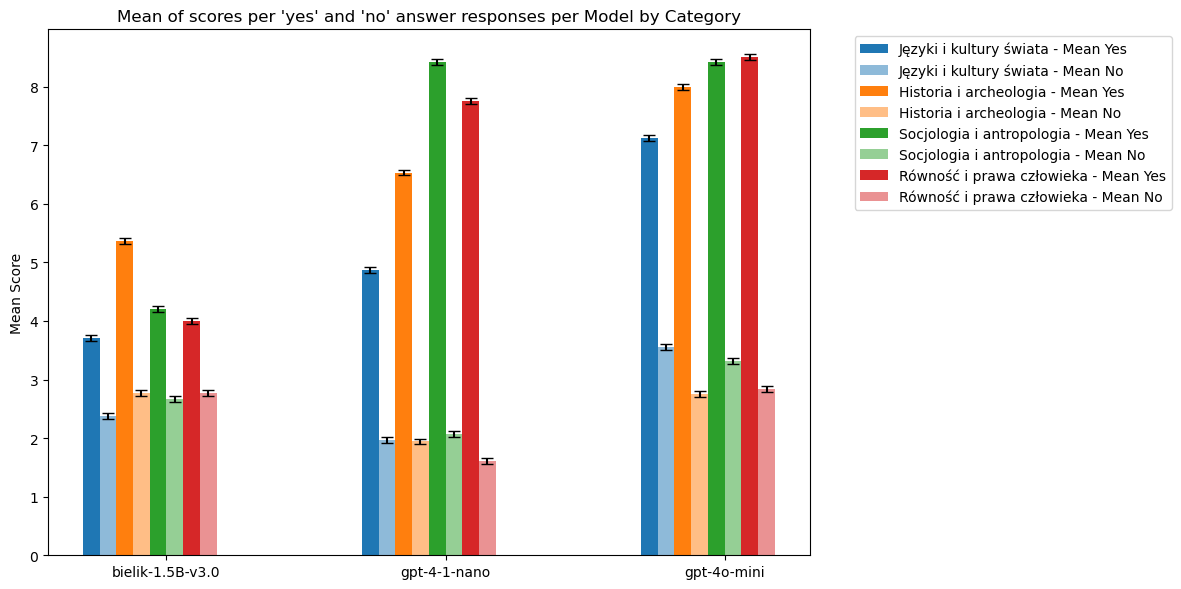

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.patches import Patch

models = list(RES_models.keys())
categories = list(next(iter(RES_models.values())).keys())

bar_width = 0.12
x = np.arange(len(models))
total_width = bar_width * len(categories)

# Prepare mean_true, mean_false and dummy CI arrays indexed by category
mean1s = [np.array([RES_models[model][cat]['mean_true'] for model in models]) for cat in categories]
mean2s = [np.array([RES_models[model][cat]['mean_false'] for model in models]) for cat in categories]

# Dummy confidence intervals (replace with your real CI if available)
mean1_ci = [np.array([0.05] * len(models)) for _ in categories]
mean2_ci = [np.array([0.05] * len(models)) for _ in categories]

# Base colors for each category
base_colors = plt.cm.tab10.colors
category_colors = {cat: base_colors[i % len(base_colors)] for i, cat in enumerate(categories)}

fig, ax = plt.subplots(figsize=(12, 6))
offset = bar_width / 2

for i, cat in enumerate(categories):
    base_color = category_colors[cat]
    mean2_color = mcolors.to_rgba(base_color, alpha=0.5)  # lighter (more transparent)
    mean1_color = mcolors.to_rgba(base_color, alpha=1.0)  # solid

    # Plot mean_true bars
    ax.bar(
        x - total_width/2 + i * bar_width - offset/2,
        mean1s[i],
        bar_width / 2,
        yerr=mean1_ci[i],
        label=f'{cat} - Mean True',
        capsize=4,
        color=mean1_color
    )

    # Plot mean_false bars
    ax.bar(
        x - total_width/2 + i * bar_width + offset/2,
        mean2s[i],
        bar_width / 2,
        yerr=mean2_ci[i],
        label=f'{cat} - Mean False',
        capsize=4,
        color=mean2_color
    )

ax.set_title("Mean of scores per 'yes' and 'no' answer responses per Model by Category")
ax.set_ylabel("Mean Score")
ax.set_xticks(x)
ax.set_xticklabels(models)

# Build legend with one entry per category for mean_true and mean_false
legend_elements = []
for cat in categories:
    base = category_colors[cat]
    legend_elements.append(Patch(facecolor=base, label=f"{cat} - Mean Yes"))
    legend_elements.append(Patch(facecolor=mcolors.to_rgba(base, 0.5), label=f"{cat} - Mean No"))

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


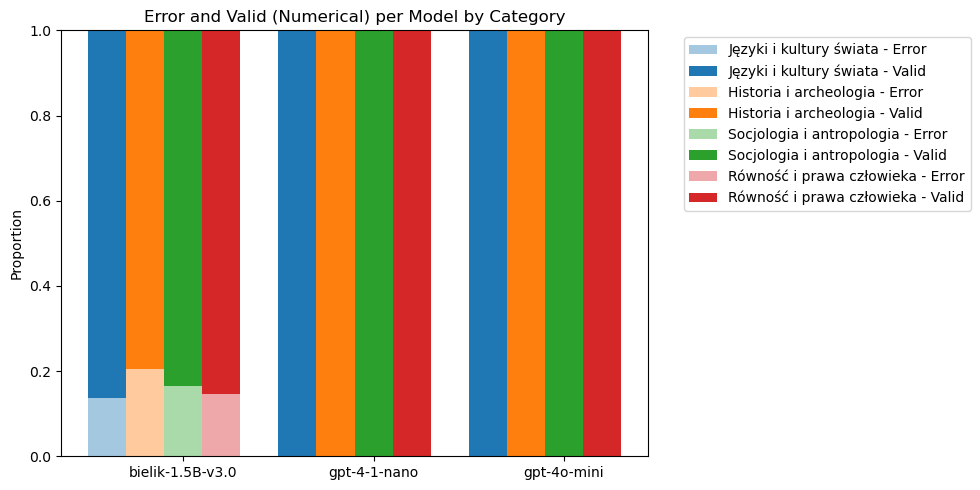

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.patches import Patch

models = list(RES_models.keys())
categories = list(next(iter(RES_models.values())).keys())

# Plot config
total_width = 0.8
n_cats = len(categories)
bar_width = total_width / n_cats
x = np.arange(len(models))

# Prepare data arrays: each is list of lists [category][model]
errors = []
valids = []
for cat in categories:
    errors.append([RES_models[model][cat].get('error_num', 0) for model in models])
    valids.append([RES_models[model][cat].get('valid_num', 0) for model in models])

# Base colors for each category
base_colors = plt.cm.tab10.colors
category_colors = {cat: base_colors[i % len(base_colors)] for i, cat in enumerate(categories)}

fig, ax = plt.subplots(figsize=(10, 5))

for i, cat in enumerate(categories):
    base_color = category_colors[cat]
    error_color = mcolors.to_rgba(base_color, alpha=0.4)  # lighter for error
    valid_color = mcolors.to_rgba(base_color, alpha=1.0)  # full opacity for valid

    xpos = x - total_width / 2 + i * bar_width
    ax.bar(xpos, errors[i], bar_width, label=f'{cat} - Error', color=error_color)
    ax.bar(xpos, valids[i], bar_width, bottom=errors[i], label=f'{cat} - Valid', color=valid_color)

ax.set_title("Error and Valid (Numerical) per Model by Category")
ax.set_ylabel("Proportion")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)

# Custom legend with alternating Error/Valid patches per category
legend_elements = []
for cat in categories:
    base = category_colors[cat]
    legend_elements.append(Patch(facecolor=mcolors.to_rgba(base, 0.4), label=f"{cat} - Error"))
    legend_elements.append(Patch(facecolor=base, label=f"{cat} - Valid"))

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


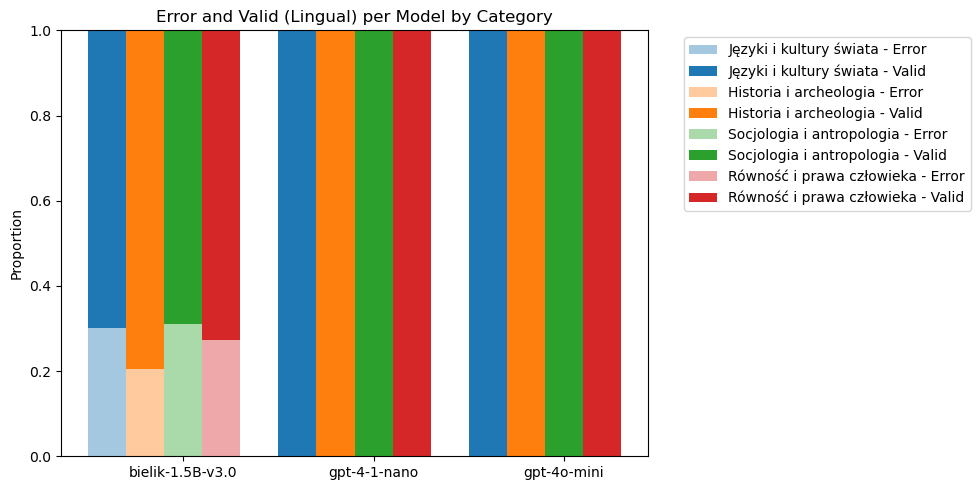

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.patches import Patch

models = list(RES_models.keys())
categories = list(next(iter(RES_models.values())).keys())

# Plot config
total_width = 0.8
n_cats = len(categories)
bar_width = total_width / n_cats
x = np.arange(len(models))

# Prepare data arrays: each is list of lists [category][model]
errors = []
valids = []
for cat in categories:
    errors.append([RES_models[model][cat].get('error_str', 0) for model in models])
    valids.append([RES_models[model][cat].get('valid_str', 0) for model in models])

# Base colors for each category
base_colors = plt.cm.tab10.colors
category_colors = {cat: base_colors[i % len(base_colors)] for i, cat in enumerate(categories)}

fig, ax = plt.subplots(figsize=(10, 5))

for i, cat in enumerate(categories):
    base_color = category_colors[cat]
    error_color = mcolors.to_rgba(base_color, alpha=0.4)  # lighter for error
    valid_color = mcolors.to_rgba(base_color, alpha=1.0)  # full opacity for valid

    xpos = x - total_width / 2 + i * bar_width
    ax.bar(xpos, errors[i], bar_width, label=f'{cat} - Error', color=error_color)
    ax.bar(xpos, valids[i], bar_width, bottom=errors[i], label=f'{cat} - Valid', color=valid_color)

ax.set_title("Error and Valid (Lingual) per Model by Category")
ax.set_ylabel("Proportion")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)

# Custom legend with alternating Error/Valid patches per category
legend_elements = []
for cat in categories:
    base = category_colors[cat]
    legend_elements.append(Patch(facecolor=mcolors.to_rgba(base, 0.4), label=f"{cat} - Error"))
    legend_elements.append(Patch(facecolor=base, label=f"{cat} - Valid"))

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


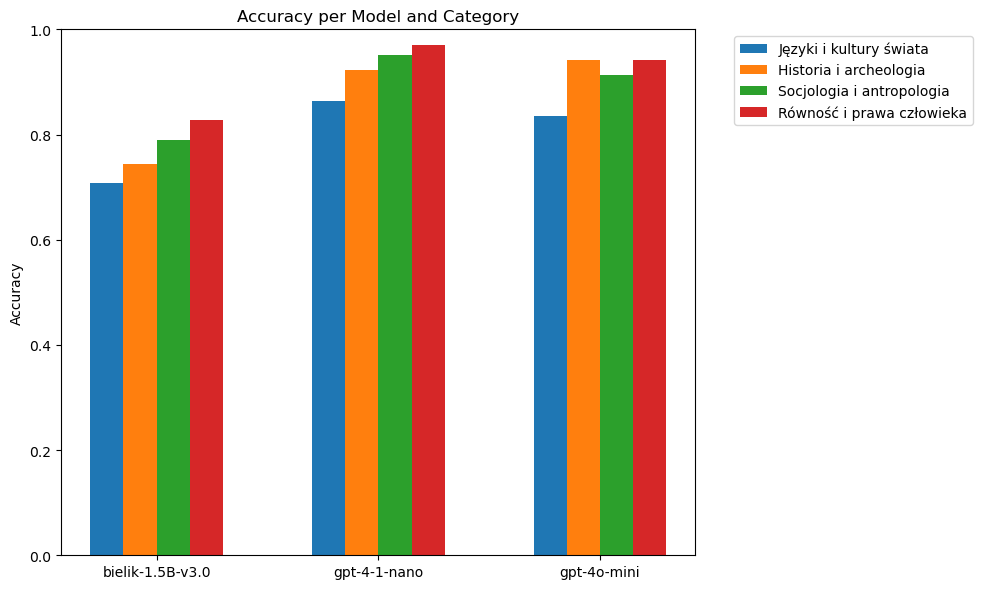

In [10]:
import matplotlib.pyplot as plt
import numpy as np

models = list(RES_models.keys())
categories = list(next(iter(RES_models.values())).keys())

bar_width = 0.15
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))

for i, cat in enumerate(categories):
    accuracies = [RES_models[model][cat].get('accuracy', 0) for model in models]
    ax.bar(x + i * bar_width, accuracies, width=bar_width, label=cat)

ax.set_xticks(x + bar_width * (len(categories) - 1) / 2)
ax.set_xticklabels(models)
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.set_title('Accuracy per Model and Category')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


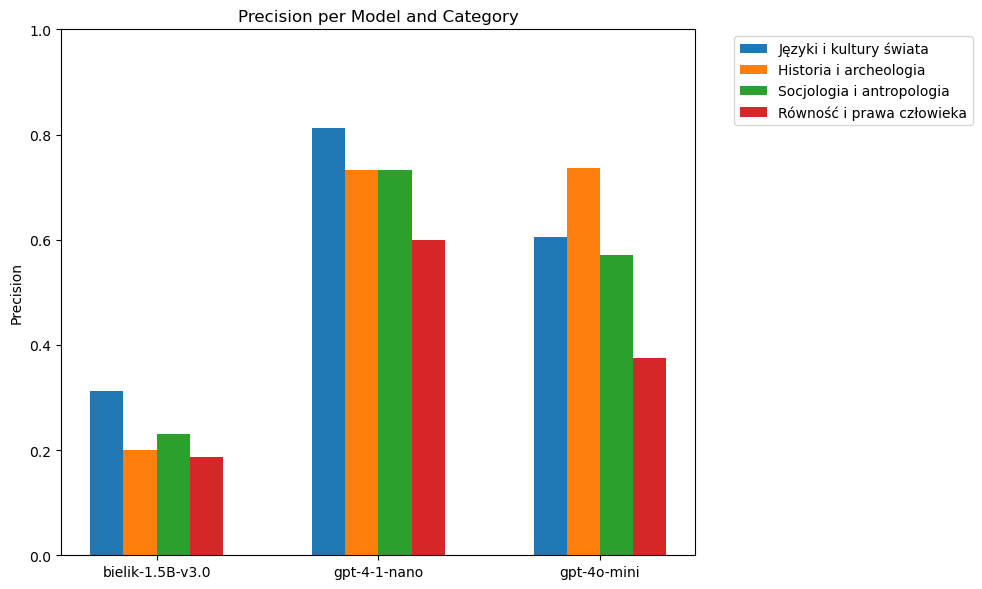

In [11]:
import matplotlib.pyplot as plt
import numpy as np

models = list(RES_models.keys())
categories = list(next(iter(RES_models.values())).keys())

bar_width = 0.15
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))

for i, cat in enumerate(categories):
    accuracies = [RES_models[model][cat].get('precision', 0) for model in models]
    ax.bar(x + i * bar_width, accuracies, width=bar_width, label=cat)

ax.set_xticks(x + bar_width * (len(categories) - 1) / 2)
ax.set_xticklabels(models)
ax.set_ylabel('Precision')
ax.set_ylim(0, 1)
ax.set_title('Precision per Model and Category')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


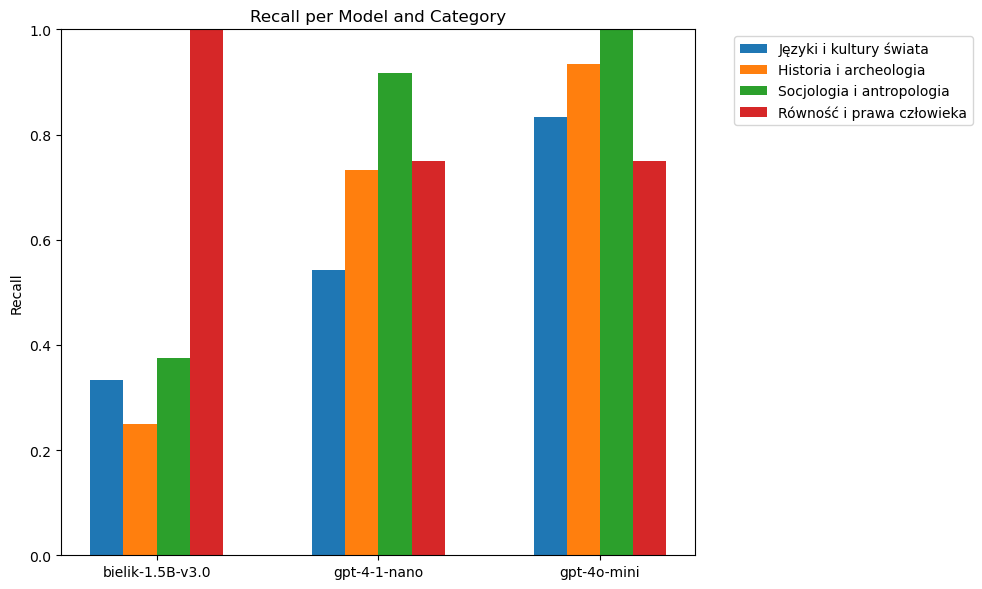

In [12]:
import matplotlib.pyplot as plt
import numpy as np

models = list(RES_models.keys())
categories = list(next(iter(RES_models.values())).keys())

bar_width = 0.15
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))

for i, cat in enumerate(categories):
    accuracies = [RES_models[model][cat].get('recall', 0) for model in models]
    ax.bar(x + i * bar_width, accuracies, width=bar_width, label=cat)

ax.set_xticks(x + bar_width * (len(categories) - 1) / 2)
ax.set_xticklabels(models)
ax.set_ylabel('Recall')
ax.set_ylim(0, 1)
ax.set_title('Recall per Model and Category')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
